## TOC:
1. [Preliminary Data Analyses](#first-bullet)

2. [Data Wrangling](#second-bullet)

3. [Exploratory Data Analyses (EDA)](#third-bullet)

4. [Modeling](#fourth-bullet)

5. [Conclusion](#fifth-bullet)

In [1]:
# Import Libraries

import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

import warnings 

warnings.filterwarnings("ignore")

In [2]:
# Load Indian liver patient data 
data=pd.read_csv('data/indian_liver_patient.csv')

## Preliminary Data Analyses <a class="anchor" id="first-bullet"></a>

In this section, we will explore given data to find missing values and learn how many features/samles we have

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [4]:
data.head().T

,0,1,2,3,4
Age,65,62,62,58,72
Gender,Female,Male,Male,Male,Male
Total_Bilirubin,0.7,10.9,7.3,1,3.9
Direct_Bilirubin,0.1,5.5,4.1,0.4,2
Alkaline_Phosphotase,187,699,490,182,195
Alamine_Aminotransferase,16,64,60,14,27
Aspartate_Aminotransferase,18,100,68,20,59
Total_Protiens,6.8,7.5,7,6.8,7.3
Albumin,3.3,3.2,3.3,3.4,2.4
Albumin_and_Globulin_Ratio,0.9,0.74,0.89,1,0.4


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,583.0,44.746141,16.189833,4.0,33.0,45.00,58.0,90.0
Total_Bilirubin,583.0,3.298799,6.209522,0.4,0.8,1.00,2.6,75.0
Direct_Bilirubin,583.0,1.486106,2.808498,0.1,0.2,0.30,1.3,19.7
Alkaline_Phosphotase,583.0,290.576329,242.937989,63.0,175.5,208.00,298.0,2110.0
Alamine_Aminotransferase,583.0,80.713551,182.620356,10.0,23.0,35.00,60.5,2000.0
Aspartate_Aminotransferase,583.0,109.910806,288.918529,10.0,25.0,42.00,87.0,4929.0
Total_Protiens,583.0,6.483190,1.085451,2.7,5.8,6.60,7.2,9.6
Albumin,583.0,3.141852,0.795519,0.9,2.6,3.10,3.8,5.5
Albumin_and_Globulin_Ratio,579.0,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8
Dataset,583.0,1.286449,0.452490,1.0,1.0,1.00,2.0,2.0


In [6]:
# Create new DataFrame that includes Male, Female patient information

disease, no_disease = data['Dataset'].value_counts()
male, female = data['Gender'].value_counts()

info=['Diognised with Liver Disease', 'Not Diognised with Liver Disease', 'Male', 'Female']
count=[disease, no_disease, male, female]

df_patient=pd.DataFrame({'Patient Info': info, 'Count': count})

In [7]:
df_patient

,Count,Patient Info
0,416,Diognised with Liver Disease
1,167,Not Diognised with Liver Disease
2,441,Male
3,142,Female


## Data Wrangling <a class="anchor" id="second-bullet"></a>

In this section, we fill out missing values with median value for the given feature. Then, we will process categorical variable 'Gender' and will create two new features 'Male' and 'Female' from it.

In [8]:
data['Albumin_and_Globulin_Ratio'].fillna(data['Albumin_and_Globulin_Ratio'].median(), inplace=True)

In [9]:
target=data['Dataset']
sex=pd.get_dummies(data['Gender'])
#data = data.join(sex)
data.insert(loc=0, column='Male', value=sex['Male'])
data.insert(loc=0, column='Female', value=sex['Female'])
data.drop(['Gender'], axis=1, inplace=True)
#data.drop(['Dataset'], axis=1, inplace=True)

In [10]:
cols = data.columns
cols = list(set(cols))
del cols[cols.index('Dataset')]
#data.hist(column=cols, bins=10, figsize=(20,20), xlabelsize = 7, color='green', log=True)
del cols[cols.index('Male')]
del cols[cols.index('Female')]

## Exploratory Data Analyses (EDA) <a class="anchor" id="third-bullet"></a>

In this section, we learn more abot data by vizualizing it on plots, which will help us in identifying outliers and other important details about the data.

In [11]:
def plot_data(cols, data, plot_type):

    fig = plt.figure(figsize = (25,25))
    
    sns.set(font_scale=1.5) 
    
    for idx, val in enumerate(cols):
            
        plt.subplot(3, 3, idx+1)

        if plot_type == 'hist':
            disease = 'sns.distplot(data[data["Dataset"] == 1].' + val + ', color="blue", label="Liver disease")'
            healthy = 'sns.distplot(data[data["Dataset"] == 2].' + val + ', color="orange", label="Healthy liver")'
            exec (disease)
            exec (healthy)
            plt.legend()
            plt.xlabel(val)
            plt.ylabel("Frequency")
          
        if plot_type == 'cdf':
            a='plt.hist(data[data["Dataset"] == 1].' + val + ',bins=50,fc=(0,1,0,0.5),label="Bening",normed = True,cumulative = True)'
            exec (a)
            sorted_data = exec('np.sort(data[data["Dataset"] == 1].' + val + ')')
            #sorted_data = exec (sorted_d)
            y = np.arange(len(sorted_data))/float(len(sorted_data)-1)
            plt.plot(sorted_data,y,color='red')
            plt.title('CDF of liver dicease bilirubin')
            
        if plot_type == 'swarm':
            condition = 'sns.swarmplot(x=' +  "'" + 'Dataset' + "'" + ',y=' + "'" + val + "'" + ',data=data)'
            print (condition)
            exec (condition)
              
        if plot_type == 'box':
            condition = 'sns.boxplot(x=' +  "'" + 'Dataset' + "'" + ',y=' + "'" + val + "'" + ',data=data)'
            print (condition)
            exec (condition)
            
        if plot_type == 'violin':
            condition = 'sns.violinplot(x=' +  "'" + 'Dataset' + "'" + ',y=' + "'" + val + "'" + ',data=data)'
            print (condition)
            exec (condition)
        
    return 0

0

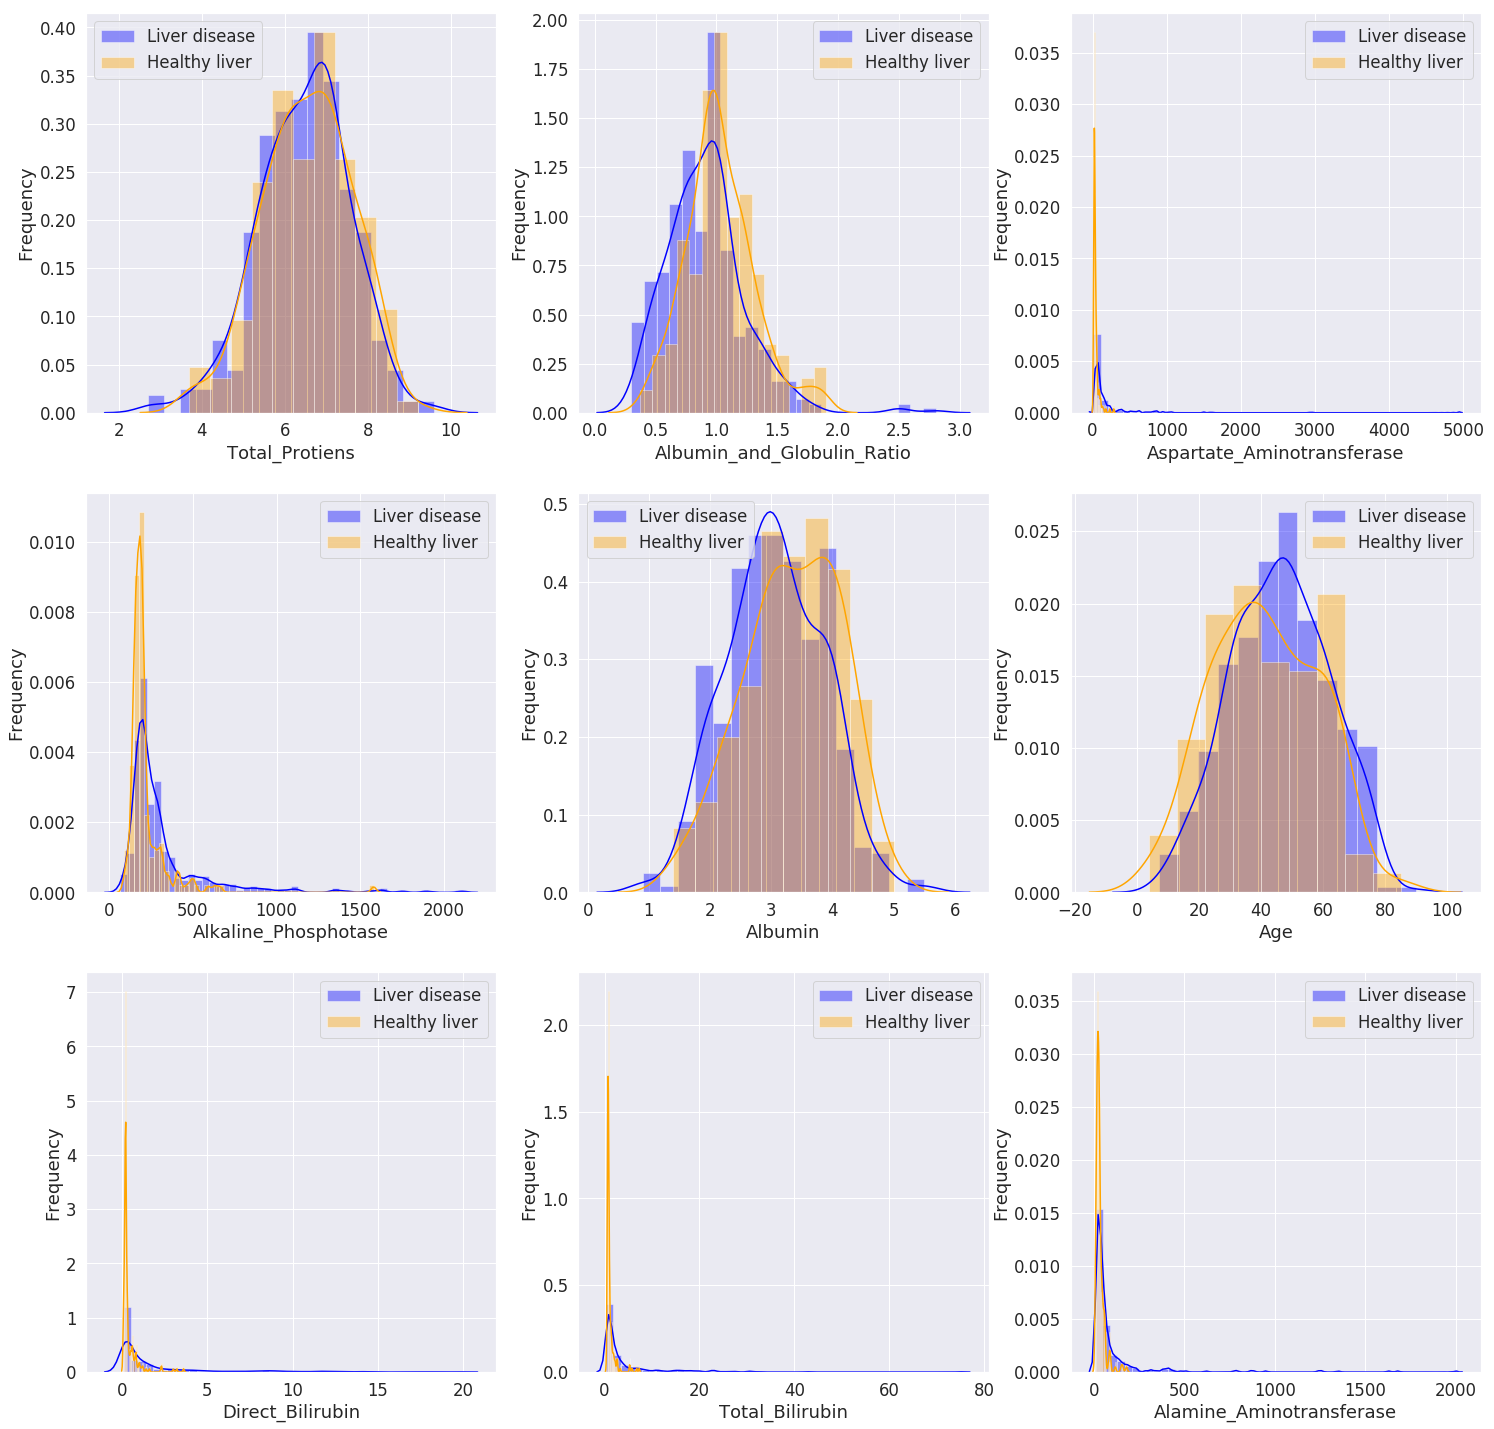

In [12]:
plot_data(cols, data, 'hist')

sns.swarmplot(x='Dataset',y='Total_Protiens',data=data)
sns.swarmplot(x='Dataset',y='Albumin_and_Globulin_Ratio',data=data)
sns.swarmplot(x='Dataset',y='Aspartate_Aminotransferase',data=data)
sns.swarmplot(x='Dataset',y='Alkaline_Phosphotase',data=data)
sns.swarmplot(x='Dataset',y='Albumin',data=data)
sns.swarmplot(x='Dataset',y='Age',data=data)
sns.swarmplot(x='Dataset',y='Direct_Bilirubin',data=data)
sns.swarmplot(x='Dataset',y='Total_Bilirubin',data=data)
sns.swarmplot(x='Dataset',y='Alamine_Aminotransferase',data=data)


0

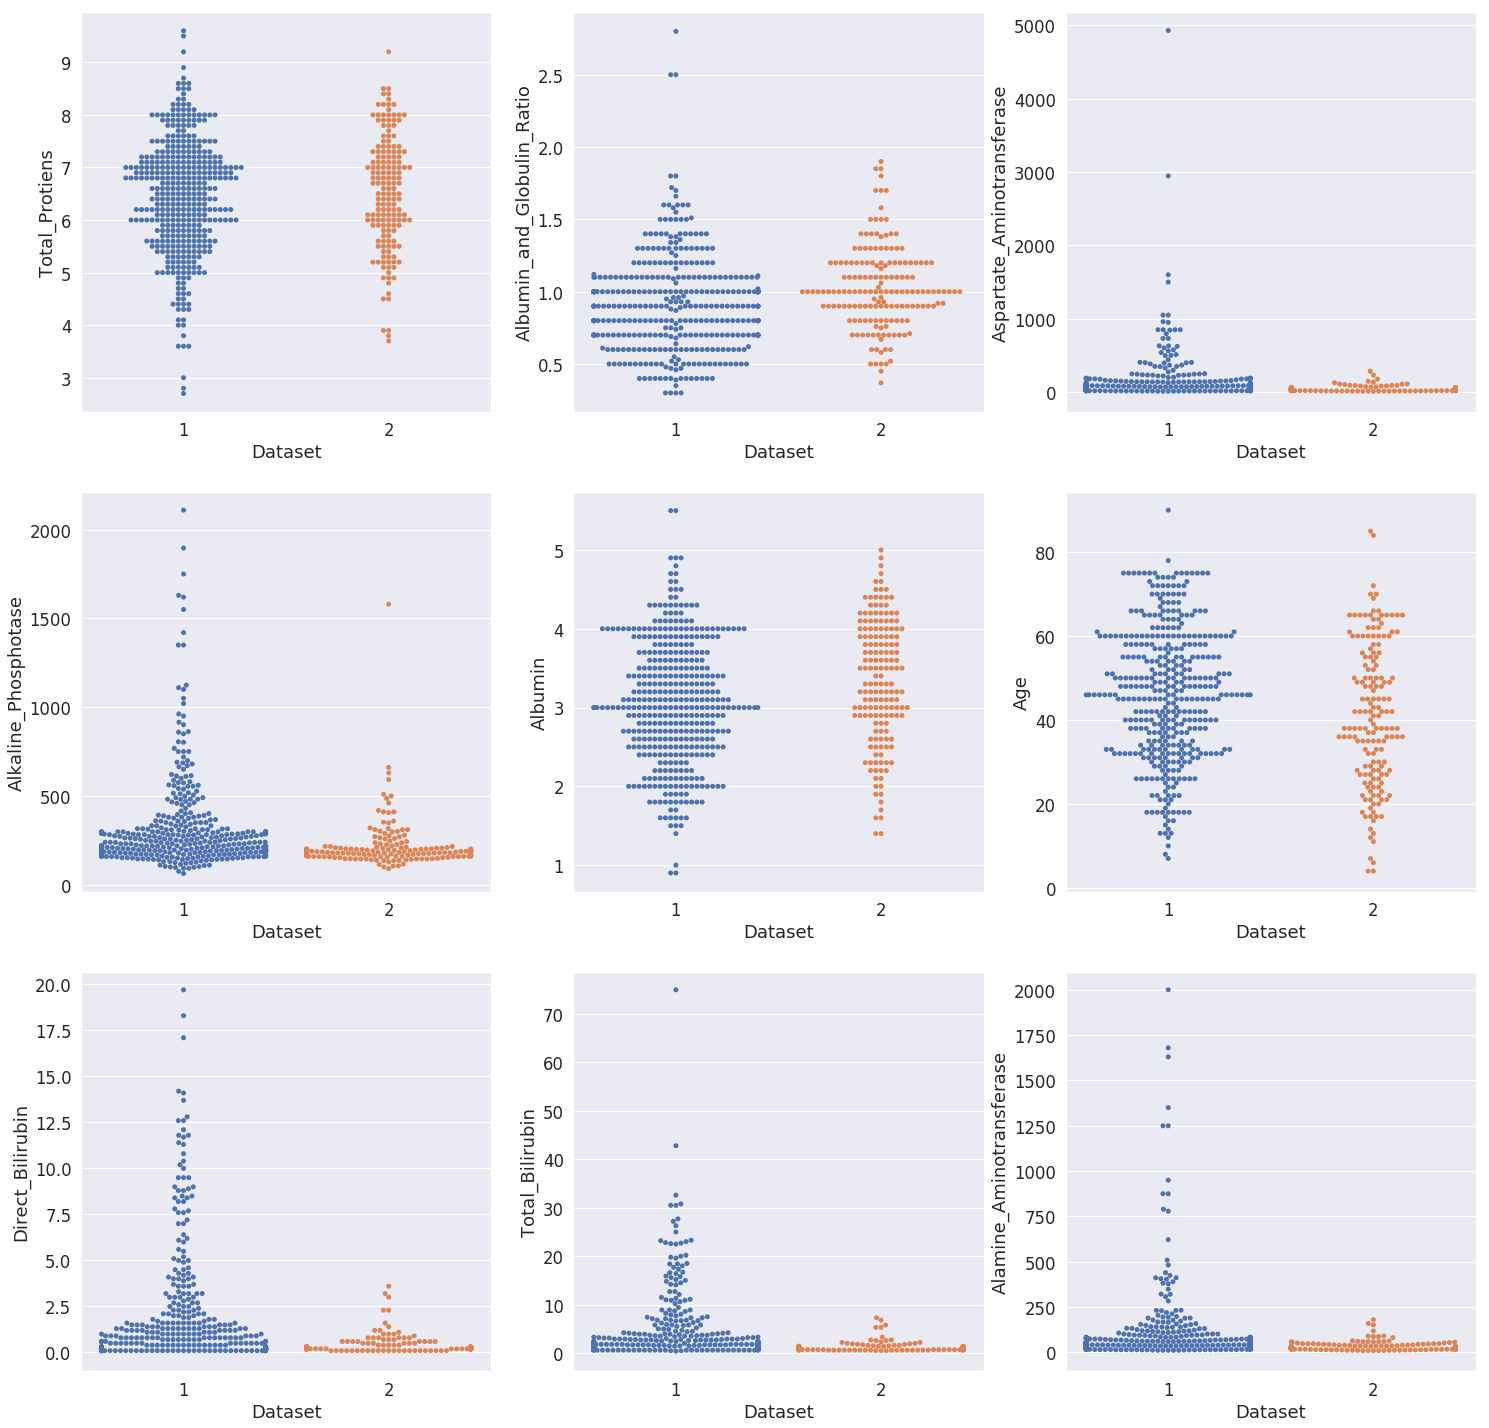

In [13]:
plot_data(cols, data, 'swarm')

sns.boxplot(x='Dataset',y='Total_Protiens',data=data)
sns.boxplot(x='Dataset',y='Albumin_and_Globulin_Ratio',data=data)
sns.boxplot(x='Dataset',y='Aspartate_Aminotransferase',data=data)
sns.boxplot(x='Dataset',y='Alkaline_Phosphotase',data=data)
sns.boxplot(x='Dataset',y='Albumin',data=data)
sns.boxplot(x='Dataset',y='Age',data=data)
sns.boxplot(x='Dataset',y='Direct_Bilirubin',data=data)
sns.boxplot(x='Dataset',y='Total_Bilirubin',data=data)
sns.boxplot(x='Dataset',y='Alamine_Aminotransferase',data=data)


0

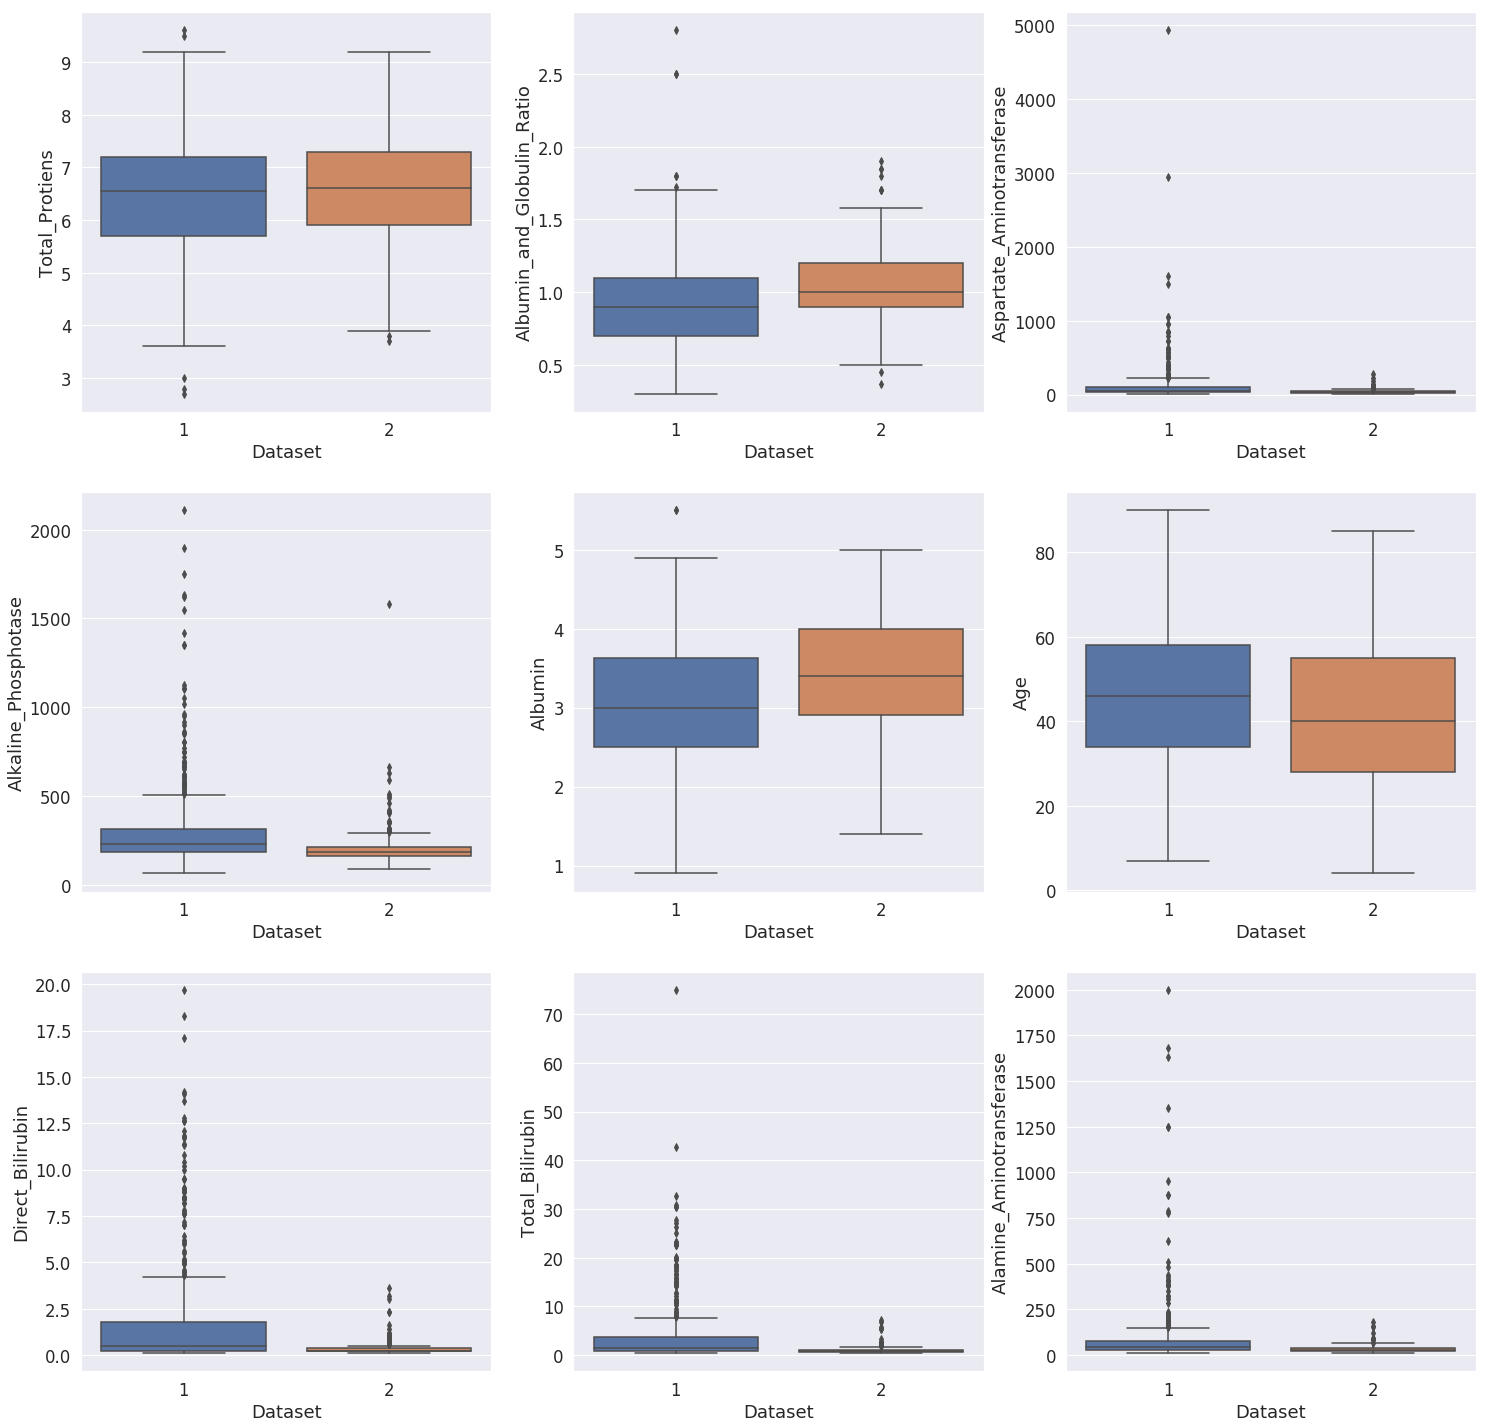

In [14]:
plot_data(cols, data, 'box')

## Modeling <a class="anchor" id="fourth-bullet"></a>

In [15]:
# Define X and y for train/test split

X = data.drop(['Dataset'], axis=1)
y = data.Dataset

cols = data.columns
cols = list(set(cols))
del cols[cols.index('Dataset')]

#### Define Parameters for Xgboost, Logistic Regression, KNNeighbors and Random Forest Classifiers

In [16]:
def XGB(X_train, y_train, X_test, y_test):
   
    import xgboost as xgb

    xgb_clf = xgb.XGBClassifier()

    params={'max_depth': [2,3,4], 'subsample': [0.6, 1.0],'colsample_bytree': [0.5, 0.6],
    'n_estimators': [500, 1000], 'reg_alpha': [0.03, 0.05]}

    xgb = GridSearchCV(xgb_clf,param_grid=params, n_jobs=-1, cv=3, scoring='f1')
    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    print('Accuracy of xgb classifier on test set: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print ("Classification report:\n{}".format(classification_report(y_test,predictions)))
    
    precision,recall,fscore,support=score(y_test,predictions)
    
    return fscore, accuracy_score(y_test, predictions)

In [17]:
#import sklearn
#sklearn.metrics.SCORERS.keys()

In [18]:
def LR(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression()
    grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
    
    lr = GridSearchCV(clf, param_grid=grid_values, cv=3, n_jobs=-1, scoring="f1")
    lr.fit(X_train, y_train)

    # make predictions on test data
    y_pred = lr.predict(X_test)

    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))
    print ("Classification report:\n{}".format(classification_report(y_test,y_pred)))
    
    precision,recall,fscore,support=score(y_test, y_pred)
    
    return fscore, accuracy_score(y_test, y_pred)

In [19]:
def KNN(X_train, y_train, X_test, y_test):
    
    reg=KNeighborsClassifier(n_neighbors=8)

    #lr = GridSearchCV(clf, param_grid=grid_values, scoring="f1")

    k_range = list(range(1, 31))
    param_grid = dict(n_neighbors=k_range)

    grid = GridSearchCV(reg, param_grid, cv=3, n_jobs=-1, scoring='f1')
    grid.fit(X_train, y_train)
       
    print('Accuracy of KNeighbors classifier on test set: {:.2f}'.format(grid.score(X_test, y_test)))
    print ("Classification report:\n{}".format(classification_report(y_test,grid.predict(X_test))))
    
    precision,recall,fscore,support=score(y_test, grid.predict(X_test))
    return fscore, accuracy_score(y_test, grid.predict(X_test))

In [20]:
def RF(X_train, y_train, X_test, y_test, flag=0):
    
    from sklearn.metrics import precision_recall_fscore_support as score
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics

    rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_split=5, oob_score=True)
    parameters = {'n_estimators':[200, 400, 600, 800, 1000], 'min_samples_leaf':[4, 8, 16], 
                  'max_features': ['auto', 'sqrt']}

    scoring = make_scorer(accuracy_score, greater_is_better=True)

    cl_rand_fr = GridSearchCV(rfc, param_grid=parameters, cv=3, n_jobs=-1, scoring='f1')
    cl_rand_fr.fit(X_train, y_train)
    cl_rand_fr = cl_rand_fr.best_estimator_

    # Show prediction accuracy score
    print ('Accuracy of random forest classifier on test set: {:.2f}'.format(accuracy_score(y_test, cl_rand_fr.predict(X_test))))
    print ("Classification report:\n{}".format(classification_report(y_test,cl_rand_fr.predict(X_test))))
    
    if flag == 1:
    
        print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, cl_rand_fr.predict(X_test))))
    
        from yellowbrick.classifier import ROCAUC
        fig, ax=plt.subplots(1,1,figsize=(12,8))

        auc=ROCAUC(cl_rand_fr, macro=False, micro=False)
        auc.fit(X_train, y_train)
        auc.score(X_test, y_test)
        auc.poof()
        
        return 0
    
    else:
        
        precision,recall,fscore,support=score(y_test, cl_rand_fr.predict(X_test))
        return fscore, accuracy_score(y_test, cl_rand_fr.predict(X_test)), cl_rand_fr.feature_importances_

In [21]:
model = ["Xgboost", "KN Neighbors", "Logistic Regression", "Random Forest"]
fsc1=[]
fsc2=[]
acc=[]
f1acc=[]
result = ["Regular", "MinMaxScaled", "Quantile", "SMOTE", "Max"]

#### Four Classifier Results for Regular Rest/Train Split 

Accuracy of xgb classifier on test set: 0.67
Classification report:
              precision    recall  f1-score   support

           1       0.76      0.78      0.77       125
           2       0.41      0.38      0.40        50

   micro avg       0.67      0.67      0.67       175
   macro avg       0.59      0.58      0.58       175
weighted avg       0.66      0.67      0.66       175

Accuracy of KNeighbors classifier on test set: 0.82
Classification report:
              precision    recall  f1-score   support

           1       0.73      0.94      0.82       125
           2       0.43      0.12      0.19        50

   micro avg       0.70      0.70      0.70       175
   macro avg       0.58      0.53      0.50       175
weighted avg       0.64      0.70      0.64       175

Accuracy of logistic regression classifier on test set: 0.83
Classification report:
              precision    recall  f1-score   support

           1       0.71      1.00      0.83       125
          

Text(0.5, 1.0, 'Feature Significance')

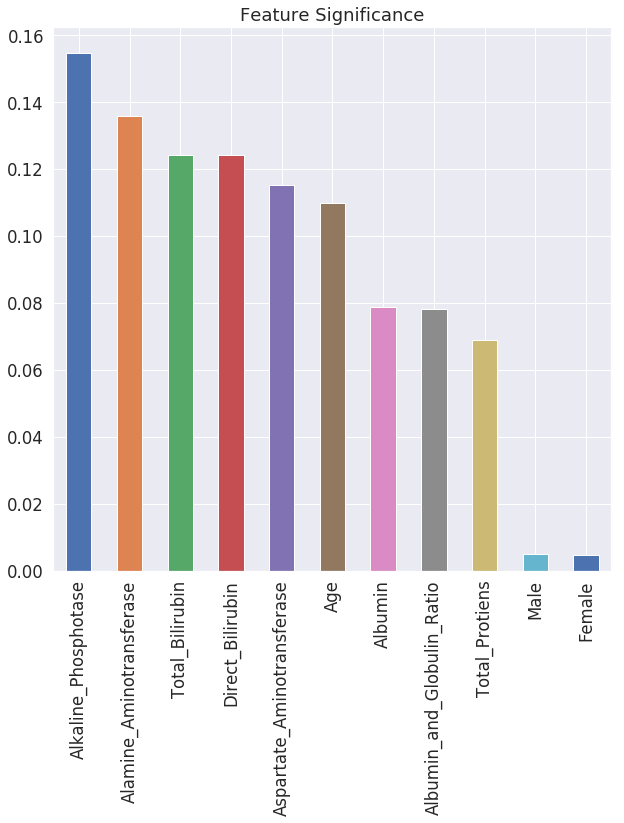

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size = 0.3, random_state=42, stratify=y)

fscore, accuracy = XGB(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = KNN(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = LR(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy, features = RF(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

coef = pd.Series(features, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
coef.head(11).plot(kind='bar')
plt.title('Feature Significance')

#### Four Classifier Results for MinMax Scaled Train/Test Split 

In [23]:
scaler=MinMaxScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

fscore, accuracy = XGB(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = KNN(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = LR(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy, features = RF(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

Accuracy of xgb classifier on test set: 0.65
Classification report:
              precision    recall  f1-score   support

           1       0.75      0.77      0.76       125
           2       0.38      0.36      0.37        50

   micro avg       0.65      0.65      0.65       175
   macro avg       0.57      0.56      0.57       175
weighted avg       0.65      0.65      0.65       175

Accuracy of KNeighbors classifier on test set: 0.83
Classification report:
              precision    recall  f1-score   support

           1       0.72      0.97      0.83       125
           2       0.50      0.08      0.14        50

   micro avg       0.71      0.71      0.71       175
   macro avg       0.61      0.52      0.48       175
weighted avg       0.66      0.71      0.63       175

Accuracy of logistic regression classifier on test set: 0.83
Classification report:
              precision    recall  f1-score   support

           1       0.71      1.00      0.83       125
          

#### Four Classifier Results with Additional Quantile Feautres for Train/Test Split

In [24]:
# Introduce quantile features and add them to dataset
scaler=MinMaxScaler()

qcut_cols=['Alkaline_Phosphotase', 'Direct_Bilirubin', 'Alamine_Aminotransferase', 'Total_Bilirubin', 'Aspartate_Aminotransferase', 'Age', 'Albumin_and_Globulin_Ratio']
important_fs=data[qcut_cols]

for i in range(len(qcut_cols)):
    new_q_f1=pd.get_dummies(pd.qcut(data[qcut_cols[i]], 4, labels=[qcut_cols[i]+"_Q0", qcut_cols[i]+"_Q1", qcut_cols[i]+"_Q2", qcut_cols[i]+"_Q3"]))
    important_fs=pd.concat([important_fs, new_q_f1], axis=1, sort=False)

new_cols=important_fs.columns.values

X_train, X_test, y_train, y_test = train_test_split(important_fs[new_cols], y, test_size = 0.3, random_state=0, stratify=y)

X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

fscore, accuracy = XGB(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = KNN(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = LR(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy, features = RF(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

Accuracy of xgb classifier on test set: 0.70
Classification report:
              precision    recall  f1-score   support

           1       0.77      0.84      0.80       125
           2       0.47      0.36      0.41        50

   micro avg       0.70      0.70      0.70       175
   macro avg       0.62      0.60      0.61       175
weighted avg       0.68      0.70      0.69       175

Accuracy of KNeighbors classifier on test set: 0.81
Classification report:
              precision    recall  f1-score   support

           1       0.72      0.93      0.81       125
           2       0.36      0.10      0.16        50

   micro avg       0.69      0.69      0.69       175
   macro avg       0.54      0.51      0.48       175
weighted avg       0.62      0.69      0.62       175

Accuracy of logistic regression classifier on test set: 0.83
Classification report:
              precision    recall  f1-score   support

           1       0.71      1.00      0.83       125
          

#### Four Classifier Results with SMOTE Oversamping for Train/Test Split

In [25]:
# SMOTE oversampling 
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score)

X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size = 0.3, random_state=0, stratify=y)

old_X_test = X_test
old_y_test = y_test

parameters = {'n_estimators':[200, 400, 600, 800, 1000], 'min_samples_leaf':[4, 8, 16], 'max_features': ['auto', 'sqrt']}
rfc = RandomForestClassifier(random_state=42, min_samples_split=5, oob_score=True)

sm = SMOTE(random_state=0, sampling_strategy=1.0, k_neighbors=7, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
X_test_res, y_test_res = sm.fit_sample(X_test, y_test.ravel())

fscore, accuracy = XGB(X_train_res, y_train_res, X_test.values, y_test.values)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = KNN(X_train_res, y_train_res, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = LR(X_train_res, y_train_res, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy, features = RF(X_train_res, y_train_res, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

Accuracy of xgb classifier on test set: 0.73
Classification report:
              precision    recall  f1-score   support

           1       0.80      0.83      0.82       125
           2       0.53      0.48      0.51        50

   micro avg       0.73      0.73      0.73       175
   macro avg       0.67      0.66      0.66       175
weighted avg       0.72      0.73      0.73       175

Accuracy of KNeighbors classifier on test set: 0.77
Classification report:
              precision    recall  f1-score   support

           1       0.79      0.76      0.77       125
           2       0.44      0.48      0.46        50

   micro avg       0.68      0.68      0.68       175
   macro avg       0.61      0.62      0.62       175
weighted avg       0.69      0.68      0.68       175

Accuracy of logistic regression classifier on test set: 0.73
Classification report:
              precision    recall  f1-score   support

           1       0.88      0.62      0.73       125
          

#### Four Classifier Results with Additional Max Value Feautres for Train/Test Split

In [26]:
# Add new features that set 1 if a sample value is above the corrsponding feature's max value, 0 otherwise.

#del qcut_cols[qcut_cols.index('Age')]
important_max=data[qcut_cols]
val = data[qcut_cols][data['Dataset'] == 2].max()
for i in range(len(qcut_cols)):
    new_max_f1=qcut_cols[i]
    important_max[new_max_f1+'_max']=np.where(important_max[new_max_f1]>val[new_max_f1], 1, 0)

new_cols_max=important_max.columns.values

X_train, X_test, y_train, y_test = train_test_split(important_max[new_cols_max], y, test_size = 0.3, random_state=0, stratify=y)

fscore, accuracy = XGB(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = KNN(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy = LR(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

fscore, accuracy, features = RF(X_train, y_train, X_test, y_test)

fsc1.append(fscore[0])
fsc2.append(fscore[1])
acc.append(accuracy)

Accuracy of xgb classifier on test set: 0.76
Classification report:
              precision    recall  f1-score   support

           1       0.81      0.87      0.84       125
           2       0.60      0.48      0.53        50

   micro avg       0.76      0.76      0.76       175
   macro avg       0.70      0.68      0.69       175
weighted avg       0.75      0.76      0.75       175

Accuracy of KNeighbors classifier on test set: 0.81
Classification report:
              precision    recall  f1-score   support

           1       0.74      0.89      0.81       125
           2       0.44      0.22      0.29        50

   micro avg       0.70      0.70      0.70       175
   macro avg       0.59      0.55      0.55       175
weighted avg       0.65      0.70      0.66       175

Accuracy of logistic regression classifier on test set: 0.83
Classification report:
              precision    recall  f1-score   support

           1       0.71      1.00      0.83       125
          

#### Modeling Results

In [27]:
table=pd.DataFrame({'Applied Method':result, 'f1 score for unhealthy patients from Xgboost':[fsc1[0], fsc1[4], fsc1[8], fsc1[12], fsc1[16]], 'f1 score for healthy patients from Xgboost':[fsc2[0], fsc2[4], fsc2[8], fsc2[12], fsc2[16]], 'f1 accuracy score for Xgboost':[acc[0], acc[4], acc[8], acc[12], acc[16]], 'f1 score for unhealthy patients from KNN':[fsc1[1], fsc1[5], fsc1[9], fsc1[13], fsc1[17]], 'f1 score for healthy patients from KNN':[fsc2[1], fsc2[5], fsc2[9], fsc2[13], fsc2[17]], 'f1 accuracy score for KNN':[acc[1], acc[5], acc[9], acc[13], acc[17]], 'f1 score for unhealthy patients from Logistic Regression':[fsc1[2], fsc1[6], fsc1[10], fsc1[14], fsc1[18]], 'f1 score for healthy patients from Logistic Regression':[fsc2[2], fsc2[6], fsc2[10], fsc2[14], fsc2[18]], 'f1 accuracy score for Logistic Regression':[acc[2], acc[6], acc[10], acc[14], acc[18]], 'f1 score for unhealthy patients from Random Forest':[fsc1[3], fsc1[7], fsc1[11], fsc1[15], fsc1[19]], 'f1 score for healthy patients from Random Forest':[fsc2[3], fsc2[7], fsc2[11], fsc2[15], fsc2[19]], 'f1 accuracy score for Random Forest':[acc[3], acc[7], acc[11], acc[15], acc[19]]})
table=table.set_index('Applied Method').T
table

Applied Method,Regular,MinMaxScaled,Quantile,SMOTE,Max
f1 accuracy score for KNN,0.702857,0.714286,0.691429,0.680000,0.697143
f1 accuracy score for Logistic Regression,0.714286,0.714286,0.714286,0.668571,0.714286
f1 accuracy score for Random Forest,0.725714,0.725714,0.720000,0.754286,0.720000
f1 accuracy score for Xgboost,0.668571,0.651429,0.702857,0.731429,0.760000
f1 score for healthy patients from KNN,0.187500,0.137931,0.156250,0.461538,0.293333
f1 score for healthy patients from Logistic Regression,0.000000,0.000000,0.000000,0.573529,0.000000
f1 score for healthy patients from Random Forest,0.351351,0.351351,0.246154,0.582524,0.140351
f1 score for healthy patients from Xgboost,0.395833,0.371134,0.409091,0.505263,0.533333
f1 score for unhealthy patients from KNN,0.818182,0.828767,0.811189,0.772358,0.807273
f1 score for unhealthy patients from Logistic Regression,0.833333,0.833333,0.833333,0.728972,0.833333


In [28]:
print ("The best f1 accuracy score for Random Forest is with SMOTE oversampled train/test split:", table['SMOTE'].loc["f1 accuracy score for Random Forest"])
print ("with f1 score for unhealthy patients:", table['SMOTE'].loc["f1 score for unhealthy patients from Random Forest"], "and f1 score for healthy patients:", table['SMOTE'].loc["f1 score for healthy patients from Random Forest"])

The best f1 accuracy score for Random Forest is with SMOTE oversampled train/test split: 0.7542857142857143
with f1 score for unhealthy patients: 0.8259109311740891 and f1 score for healthy patients: 0.5825242718446602


Accuracy of random forest classifier on test set: 0.75
Classification report:
              precision    recall  f1-score   support

           1       0.84      0.82      0.83       125
           2       0.57      0.60      0.58        50

   micro avg       0.75      0.75      0.75       175
   macro avg       0.70      0.71      0.70       175
weighted avg       0.76      0.75      0.76       175

Confusion Matrix:
[[102  23]
 [ 20  30]]


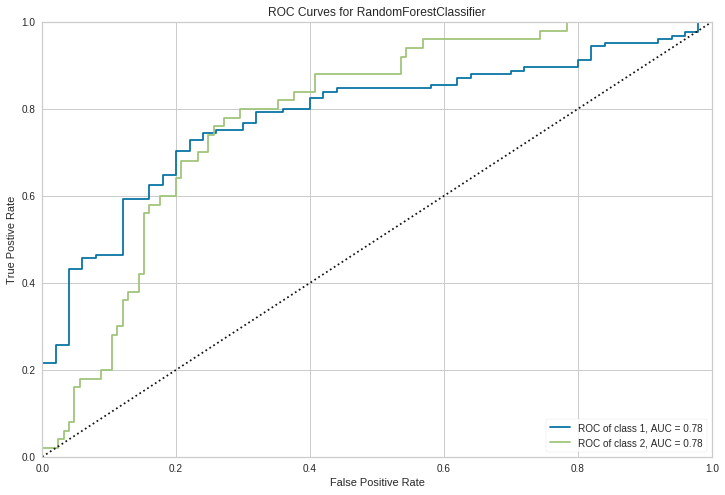

0

In [29]:
RF(X_train_res, y_train_res, old_X_test, old_y_test, 1)

### Correlation Analysis

In [29]:
num_cols = data._get_numeric_data().columns
cor = data[num_cols].corr()

threshold = 0.7

corlist = []

for i in range(0,len(num_cols)):
    for j in range(i+1,len(num_cols)):
        if (j != i and cor.iloc[i,j] <= 1 ) or (j != i and cor.iloc[i,j] >= -1):
            corlist.append([cor.iloc[i,j],i,j]) 

#Sort higher correlations first            
sort_corlist = sorted(corlist,key=lambda x: -abs(x[0]))

In [30]:
x_plot=[]
y_plot=[]
for x,i,j in sort_corlist:
    if num_cols[i] != 'Dataset' and num_cols[j] != 'Dataset':
        print (num_cols[i],num_cols[j],x)
        x_plot.append(num_cols[i])
        y_plot.append(num_cols[j])

Female Male -1.0
Total_Bilirubin Direct_Bilirubin 0.8746179301164149
Alamine_Aminotransferase Aspartate_Aminotransferase 0.7919656848536135
Total_Protiens Albumin 0.7840533353871901
Albumin Albumin_and_Globulin_Ratio 0.6860914626301073
Age Albumin -0.2659243613007011
Direct_Bilirubin Aspartate_Aminotransferase 0.2575439810938503
Total_Bilirubin Aspartate_Aminotransferase 0.23783132253123318
Direct_Bilirubin Alkaline_Phosphotase 0.23493870581881707
Direct_Bilirubin Alamine_Aminotransferase 0.23389405445942543
Total_Protiens Albumin_and_Globulin_Ratio 0.23382801077268944
Alkaline_Phosphotase Albumin_and_Globulin_Ratio -0.2337841167260578
Direct_Bilirubin Albumin -0.22853057292087228
Total_Bilirubin Albumin -0.2222504060257662
Age Albumin_and_Globulin_Ratio -0.2159675924953045
Total_Bilirubin Alamine_Aminotransferase 0.2140647401836328
Total_Bilirubin Alkaline_Phosphotase 0.20666879518008952
Total_Bilirubin Albumin_and_Globulin_Ratio -0.20601518222165344
Direct_Bilirubin Albumin_and_Globu

In [31]:
x_m_plot=[]
y_m_plot=[]
for x,i,j in sort_corlist:
    if num_cols[i] != 'Dataset' and num_cols[j] != 'Dataset':
        if x >= 0.60:
            x_m_plot.append(num_cols[i])
            y_m_plot.append(num_cols[j])
            print (num_cols[i],num_cols[j],x)

Total_Bilirubin Direct_Bilirubin 0.8746179301164149
Alamine_Aminotransferase Aspartate_Aminotransferase 0.7919656848536135
Total_Protiens Albumin 0.7840533353871901
Albumin Albumin_and_Globulin_Ratio 0.6860914626301073


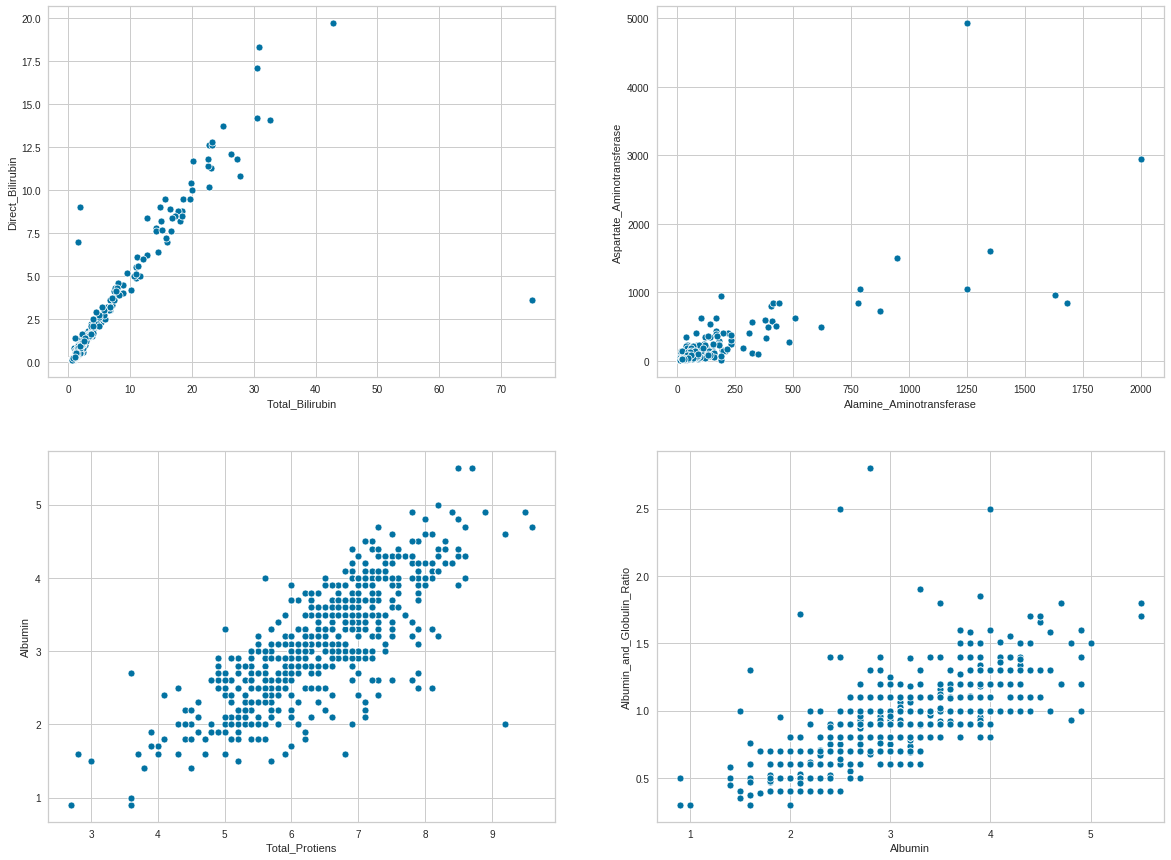

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes=axes.flatten()
for i in range(len(x_m_plot)):
    sns.scatterplot(data=data, x=x_m_plot[i], y=y_m_plot[i], ax=axes[i])

## Conclusion <a class="anchor" id="fifth-bullet"></a>

We investigated the Liver patients dataset and applied machine learning algorithms to predict the patient disease. Our observations revealed that the distribution of patients with and without disease significantly differ. Specifically, we observe that the healthy patients have higher frequency of small values in narrow ranges for total bilirubin, direct bilirubin,   aspertate aminotransferace and alkaline phosphotase compared to unhealthy patients.

Several ML algorithms were used to predict the ourcome on test data. We used logistic regression, xgboost, random forest and KNeighbour classifier with gridsearch parameters. Overall, all these algorithms had approximatelly the same accuracy on test data set ~ 70%. 

Also, SMOTE oversampling was applied to improve the imbalance Dataset feature for liver patient disease outcome, since it was a binary variable. Our results demonstrated that random forset with SMOTE produced better f1 score on both classes. The reason for choosing random forest with SMOTE was due to the fact that the RF algorithm is not sensitive to the unormalized dataset.

We found 4 pairs of strongly correlated features: direct and total bilirubin, aspertate aminotransferace and alamine aminotransferace, albumin and total proteins, albumin and globulin ratio and albumin. 

Overall, this analyses and techniques could be used in liver patient and other disease diagnostics. 